<a href="https://colab.research.google.com/github/SahilRaj06/Customer-segmentation/blob/main/Copy_of_customer_segmentation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [ ]:
customer_data = pd.read_csv('/content/Mall_Customers.csv')


In [ ]:
print(customer_data.info())
print(customer_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000    

In [ ]:

print("Missing values per column:")
print(customer_data.isnull().sum())
customer_data.dropna(inplace=True)


Missing values per column:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [ ]:

customer_data.drop_duplicates(inplace=True)

In [ ]:
X = customer_data.iloc[:, [ 3, 4]].values

In [ ]:
# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:1408: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(


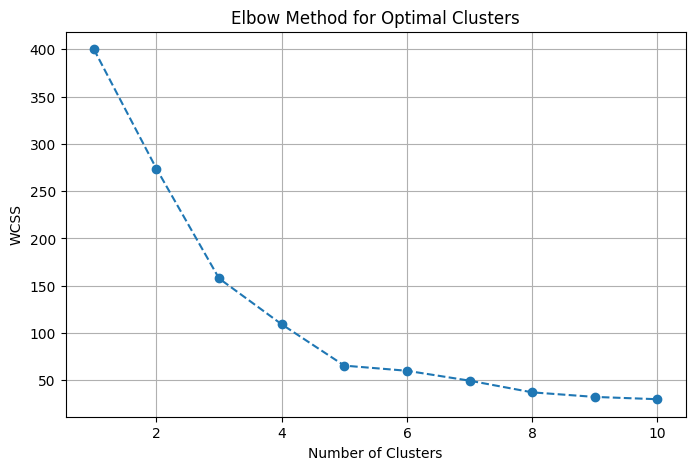

In [ ]:
# Finding the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', algorithm='elkan', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


In [ ]:

best_clusters = 2
best_silhouette = -1
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', algorithm='elkan', random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > best_silhouette:
        best_silhouette = score
        best_clusters = i

print(f'Optimal number of clusters: {best_clusters} with silhouette score: {best_silhouette:.4f}')

Optimal number of clusters: 5 with silhouette score: 0.5547


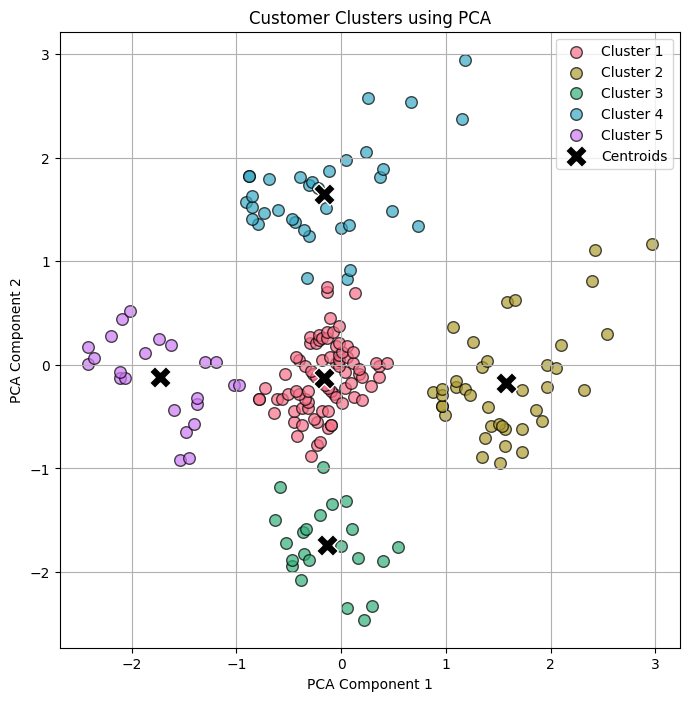

In [ ]:
# Applying K-Means with optimal clusters
kmeans = KMeans(n_clusters=best_clusters, init='k-means++', algorithm='elkan', random_state=42)
Y = kmeans.fit_predict(X_scaled)

# Apply PCA before clustering to improve separation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters with PCA
plt.figure(figsize=(8,8))
colors = sns.color_palette("husl", best_clusters)
for i in range(best_clusters):
    plt.scatter(X_pca[Y == i, 0], X_pca[Y == i, 1], s=70, c=[colors[i]], label=f'Cluster {i+1}', alpha=0.7, edgecolors='black')

# Compute PCA for cluster centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=250, c='black', label='Centroids', edgecolors='white', marker='X')

plt.title('Customer Clusters using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

sil_score = silhouette_score(X_scaled, Y)
db_score = davies_bouldin_score(X_scaled, Y)
print(f'Updated Silhouette Score: {sil_score:.4f}')



Updated Silhouette Score: 0.5547


Optimal number of clusters: 2 with silhouette score: 0.6352 and covariance type: full


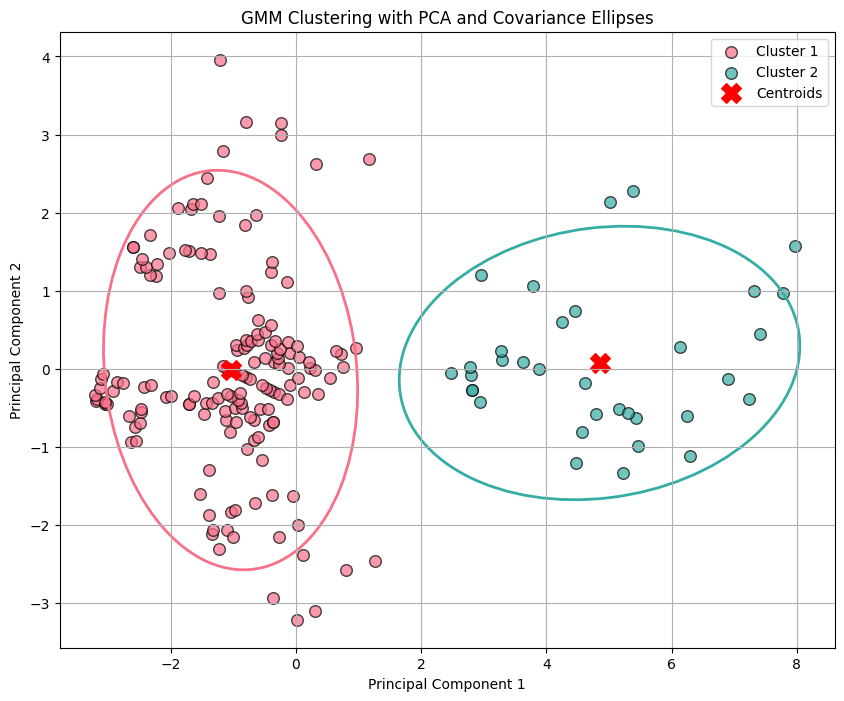

Final Silhouette Score (Original Data): 0.6352


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# STEP 1: Feature Engineering (Increase polynomial degree)
poly = PolynomialFeatures(degree=3, include_bias=False)  # Try degree 3 for more interaction
X_poly = poly.fit_transform(X)


# STEP 1: Feature Engineering (Increase polynomial degree)
poly = PolynomialFeatures(degree=3, include_bias=False)  # Try degree 3 for more interaction
X_poly = poly.fit_transform(X)

# STEP 2: Outlier Removal using Z-score (Same approach)
z_scores = np.abs(stats.zscore(X_poly))
threshold = 3
X_clean = X_poly[(z_scores < threshold).all(axis=1)]

# STEP 3: Standardize the cleaned data using RobustScaler (handles outliers better)
scaler = RobustScaler()
X_scaled_clean = scaler.fit_transform(X_clean)

# STEP 4: Find the best number of clusters using GMM with more iterations and covariance types
best_clusters = 2
best_silhouette = -1

for i in range(2, 21):
    for cov_type in ['full', 'diag', 'tied', 'spherical']:
        gmm = GaussianMixture(n_components=i, covariance_type=cov_type, random_state=42, init_params='kmeans', max_iter=500)
        labels = gmm.fit_predict(X_scaled_clean)
        score = silhouette_score(X_scaled_clean, labels)
        if score > best_silhouette:
            best_silhouette = score
            best_clusters = i
            best_cov_type = cov_type

print(f'Optimal number of clusters: {best_clusters} with silhouette score: {best_silhouette:.4f} and covariance type: {best_cov_type}')

# STEP 5: Fit final GMM on cleaned and engineered data
gmm = GaussianMixture(n_components=best_clusters, covariance_type=best_cov_type, random_state=42, init_params='kmeans')
Y = gmm.fit_predict(X_scaled_clean)

# STEP 6: Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_clean)

# Transform GMM means and covariances to PCA space
means_pca = pca.transform(gmm.means_)

# Handle covariance types and drawing ellipses
covariances = gmm.covariances_ if hasattr(gmm, 'covariances_') else []

# STEP 7: Plot clusters
plt.figure(figsize=(10, 8))
colors = sns.color_palette("husl", best_clusters)

for i, color in enumerate(colors):
    plt.scatter(X_pca[Y == i, 0], X_pca[Y == i, 1], s=70, c=[color], label=f'Cluster {i+1}', alpha=0.7, edgecolors='black')

    # Draw covariance ellipses
    if len(covariances) > 0:
        cov_matrix = covariances[i]
        if gmm.covariance_type == 'full':
            cov_pca = pca.components_ @ cov_matrix @ pca.components_.T
        elif gmm.covariance_type == 'diag':
            cov_pca = pca.components_ @ np.diag(cov_matrix) @ pca.components_.T
        elif gmm.covariance_type == 'spherical':
            cov_pca = np.diag(cov_matrix)
        else:
            continue

        eigvals, eigvecs = np.linalg.eigh(cov_pca)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        width, height = 2 * 2 * np.sqrt(eigvals)

        ellipse = Ellipse(xy=means_pca[i], width=width, height=height, angle=angle,
                          edgecolor=color, fc='None', lw=2)
        plt.gca().add_patch(ellipse)

# Plot cluster centers
plt.scatter(means_pca[:, 0], means_pca[:, 1], s=200, c='red', marker='X', label='Centroids')

plt.title('GMM Clustering with PCA and Covariance Ellipses')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# STEP 8: Evaluation Metrics on cleaned data
sil_score = silhouette_score(X_scaled_clean, Y)
db_score = davies_bouldin_score(X_scaled_clean, Y)

print(f'Final Silhouette Score (Original Data): {sil_score:.4f}')


Optimal number of clusters: 5 with silhouette score: 0.5537


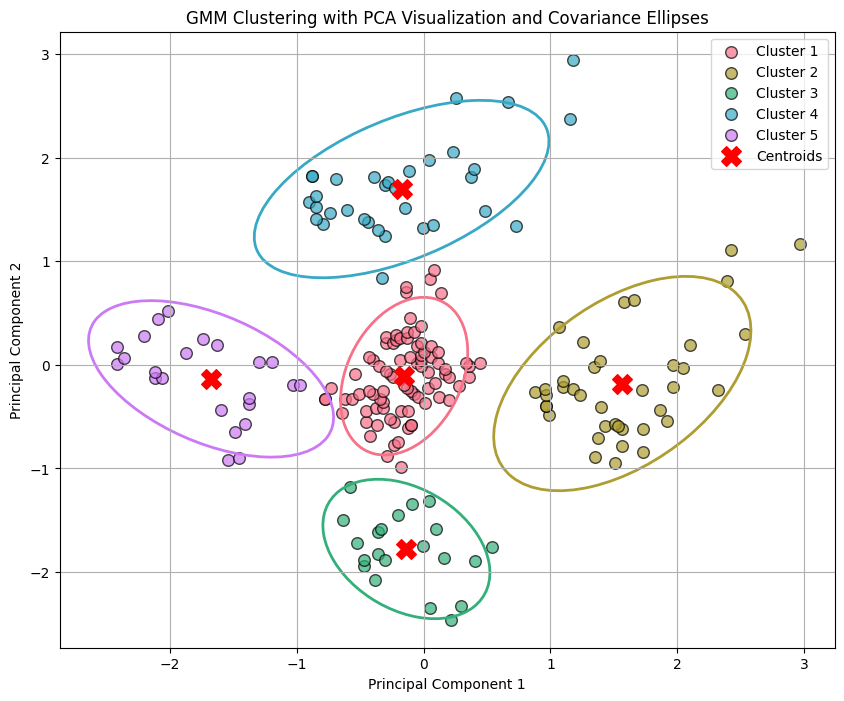

Final Silhouette Score (Original Data): 0.5537
Davies-Bouldin Score (Original Data): 0.5760


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
import numpy as np

# STEP 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Replace X with your dataset

# STEP 2: Find best number of clusters using GMM
best_clusters = 2
best_silhouette = -1

for i in range(2, 11):
    gmm = GaussianMixture(n_components=i, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > best_silhouette:
        best_silhouette = score
        best_clusters = i

print(f'Optimal number of clusters: {best_clusters} with silhouette score: {best_silhouette:.4f}')

# STEP 3: Fit final GMM
gmm = GaussianMixture(n_components=best_clusters, covariance_type='full', random_state=42)
Y = gmm.fit_predict(X_scaled)

# STEP 4: Apply PCA for visualization (2D only)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Transform GMM means and covariances to PCA space
means_pca = pca.transform(gmm.means_)
covariances = gmm.covariances_

# STEP 5: Plot clusters
plt.figure(figsize=(10, 8))
colors = sns.color_palette("husl", best_clusters)

for i, color in enumerate(colors):
    plt.scatter(X_pca[Y == i, 0], X_pca[Y == i, 1], s=70, c=[color], label=f'Cluster {i+1}',
                alpha=0.7, edgecolors='black')

    # Draw covariance ellipse
    cov_matrix = covariances[i]
    if gmm.covariance_type == 'full':
        cov_pca = pca.components_ @ cov_matrix @ pca.components_.T
    elif gmm.covariance_type == 'diag':
        cov_pca = pca.components_ @ np.diag(cov_matrix) @ pca.components_.T
    else:
        continue  # Skip other types for simplicity

    # Ellipse for 95% confidence interval (2 standard deviations)
    eigvals, eigvecs = np.linalg.eigh(cov_pca)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * 2 * np.sqrt(eigvals)  # 2 standard deviations

    ellipse = Ellipse(xy=means_pca[i], width=width, height=height, angle=angle,
                      edgecolor=color, fc='None', lw=2)
    plt.gca().add_patch(ellipse)

# Plot cluster centers
plt.scatter(means_pca[:, 0], means_pca[:, 1], s=200, c='red', marker='X', label='Centroids')

plt.title('GMM Clustering with PCA Visualization and Covariance Ellipses')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# STEP 6: Evaluation Metrics on original data (not PCA)
sil_score = silhouette_score(X_scaled, Y)
db_score = davies_bouldin_score(X_scaled, Y)

print(f'Final Silhouette Score (Original Data): {sil_score:.4f}')
print(f'Davies-Bouldin Score (Original Data): {db_score:.4f}')
